# Sentinel-2 <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
    * One step of the analysis ('Sentinel-2 Near Real Time') is currently only compatible with the DEA Sandbox
* **Products used:** 
[s2a_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_ard_granule), 
[s2b_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_ard_granule),
[s2a_nrt_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_nrt_granule), 
[s2b_nrt_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_nrt_granule)


## Background

Sentinel-2 is an Earth observation mission from the EU Copernicus Programme that systematically acquires optical imagery at high spatial resolution (up to 10 m for some bands).
The mission is based on a constellation of two identical satellites in the same orbit, 180° apart for optimal coverage and data delivery.
Together, they cover all Earth's land surfaces, large islands, inland and coastal waters every 3-5 days.

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [1]:
import sys
import datacube
import urllib.request, json
import geopandas as gpd
import datetime
from pprint import pprint

def stac_search(product,
                start_time,
                end_time,
                bbox,
                limit=100,
                root_url='https://explorer-aws.dea.ga.gov.au/stac'):

    # Create STAC URL
    bbox = f'&bbox={str(bbox).replace(" ", "")}' if bbox else ''
    stac_url = f'{root_url}/search?collection={product}&time={start_time}/{end_time}{bbox}&limit={limit}'

    # Load data
    with urllib.request.urlopen(stac_url) as url:
        data = json.loads(url.read().decode())

    return data


def s2_metadata_provisional(start_time, end_time, bbox, product='ga_s2am_ard_provisional_3'):

    # Load metadata from STAC
    s2a_provisional = stac_search(product='ga_s2am_ard_provisional_3', start_time=start_time, end_time=end_time, bbox=bbox)
    s2b_provisional = stac_search(product='ga_s2bm_ard_provisional_3', start_time=start_time, end_time=end_time, bbox=bbox)
    s2_provisional = s2a_provisional['features'] + s2b_provisional['features']

    s2_provisional_stats = [[
        'fmask_0.5.5', site_name, i['properties']['odc:region_code'],
        i['properties']['fmask:cloud'], i['properties']['fmask:cloud_shadow'],
        i['properties']['fmask:snow'], i['properties']['fmask:water'],
        i['properties']['fmask:clear']
    ] for i in s2_provisional]
    s2_provisional_stats_df = pd.DataFrame(s2_provisional_stats,
                                           columns=[
                                               'fmask', 'site', 'region_code', 'cloud_perc',
                                               'shadow_perc', 'snow_perc',
                                               'water_perc', 'clear_perc'
                                           ]).groupby('region_code').max()
    return s2_provisional_stats_df


def s2_metadata_current(region_codes, start_time):

    out_list = []

    for region_code in region_codes:

        def filter_region_code(i, region_code=region_code):
            return True if region_code in i.metadata_doc['tile_id'] else False

        dss1 = dc.find_datasets(product='s2a_nrt_granule', time=start_time, dataset_predicate=filter_region_code)
        dss2 = dc.find_datasets(product='s2a_nrt_granule', time=start_time, dataset_predicate=filter_region_code)
        dss = dss1 + dss2
        ds = dc.load(datasets=dss, output_crs=dss[0].crs, resolution=(-10, 10), resampling='nearest', measurements='fmask')

#             return ds

        nodata = (ds.fmask == 0).sum().item()
        valid = (ds.fmask == 1).sum().item()
        cloud = (ds.fmask == 2).sum().item()
        shadow = (ds.fmask == 3).sum().item()
        snow = (ds.fmask == 4).sum().item()
        water = (ds.fmask == 5).sum().item()
        total_good = valid + cloud + shadow + snow + water

        s2_current_dict = {
            'fmask': 'fmask_0.3.3',
            'site': site_name,
            'region_code': region_code,
            'cloud_perc': (cloud / total_good) * 100,
            'shadow_perc': (shadow / total_good) * 100,
            'snow_perc': (snow / total_good) * 100,
            'water_perc': (water / total_good) * 100,
            'clear_perc': (valid / total_good) * 100,
        }

        out_list.append(s2_current_dict)

    s2_current_stats_df = pd.DataFrame(out_list).set_index('region_code')
    return s2_current_stats_df

# sys.path.append("../Scripts")
# from dea_datahandling import mostcommon
# from dea_plotting import rgb


dc = datacube.Datacube(app="Sentinel_2")

/env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


## Load Sentinel-2 data from STAC

### Load sites from CSV


In [2]:
import pandas as pd
sites_df = pd.read_csv('Sentinel2_cloud_free_test_locations.csv', parse_dates=['Date'])
sites_df

,Date,UL,BR,Comment
0,2021-08-18 02:02:17+00:00,"-16.66997, 123.01972","-17.61996, 124.23684",King Sound
1,2021-08-18 02:03:33+00:00,"-21.77799, 122.57957","-22.85390, 124.25057",Karlamilyi Salt Lakes
2,2021-08-19 02:23:17+00:00,"-19.89611, 119.19076","-20.18436, 119.98609",Pilbara Coast
3,2021-08-19 01:30:51+00:00,"-12.14540, 131.61984","-12.47608, 132.20792",Pt Stuart NT
4,2021-08-20 00:15:18+00:00,"-30.56420, 147.07361","-31.15822, 147.88672",Agricultural
5,2021-08-27 00:56:46+00:00,"-34.42231, 138.18237","-35.06213, 138.74568",Adelaide
6,2021-08-27 00:52:03+00:00,"-17.48136, 140.42238","-17.77186, 140.80320",Flinders Salt/Mud flats
7,2021-08-27 00:04:21+00:00,"-27.35368, 152.72335","-27.95523, 153.38068",Brisbane
8,2021-08-28 00:27:23+00:00,"-37.55199, 144.66642","-38.09319, 145.39087",Melbourne
9,2021-09-01 00:05:43+00:00,"-32.23132, 150.63014","-32.72308, 151.12582",Hunter Coal Mines


In [65]:
all_list = []

for i, site in sites_df.iterrows():
    
    site_name = site.Comment
    print(site_name)

    # Extract bounds and time
    ymax, xmin = [float(i) for i in site.UL.split(', ')]
    ymin, xmax = [float(i) for i in site.BR.split(', ')]
    start_time = site.Date.strftime("%Y-%m-%d")
    end_time = (site.Date + datetime.timedelta(days=1)).strftime("%Y-%m-%d")
    bbox = [xmin, ymin, xmax, ymax]

    s2_provisional_stats_df = s2_metadata_provisional(
        start_time=start_time,
        end_time=end_time,
        bbox=bbox,
        product='ga_s2am_ard_provisional_3')

    try:
        s2_current_stats_df = s2_metadata_current(region_codes=s2_provisional_stats_df.index, 
                                                  start_time=start_time)
        all_list.append(s2_current_stats_df)
        all_list.append(s2_provisional_stats_df)
    except:
        pass


King Sound
Karlamilyi Salt Lakes
Pilbara Coast
Pt Stuart NT
Agricultural
Adelaide
Flinders Salt/Mud flats
Brisbane
Melbourne
Hunter Coal Mines
Canberra
Sydney


In [67]:
all_df = pd.concat(all_list).reset_index()
all_df = all_df.groupby(['site', 'fmask']).mean().reset_index()
all_melted_df = pd.melt(all_df, id_vars=["site", 'fmask'], var_name="class", value_name="perc")
all_melted_df = all_melted_df[(all_melted_df['class'] != 'clear_perc') & (all_melted_df['class'] != 'water_perc')]

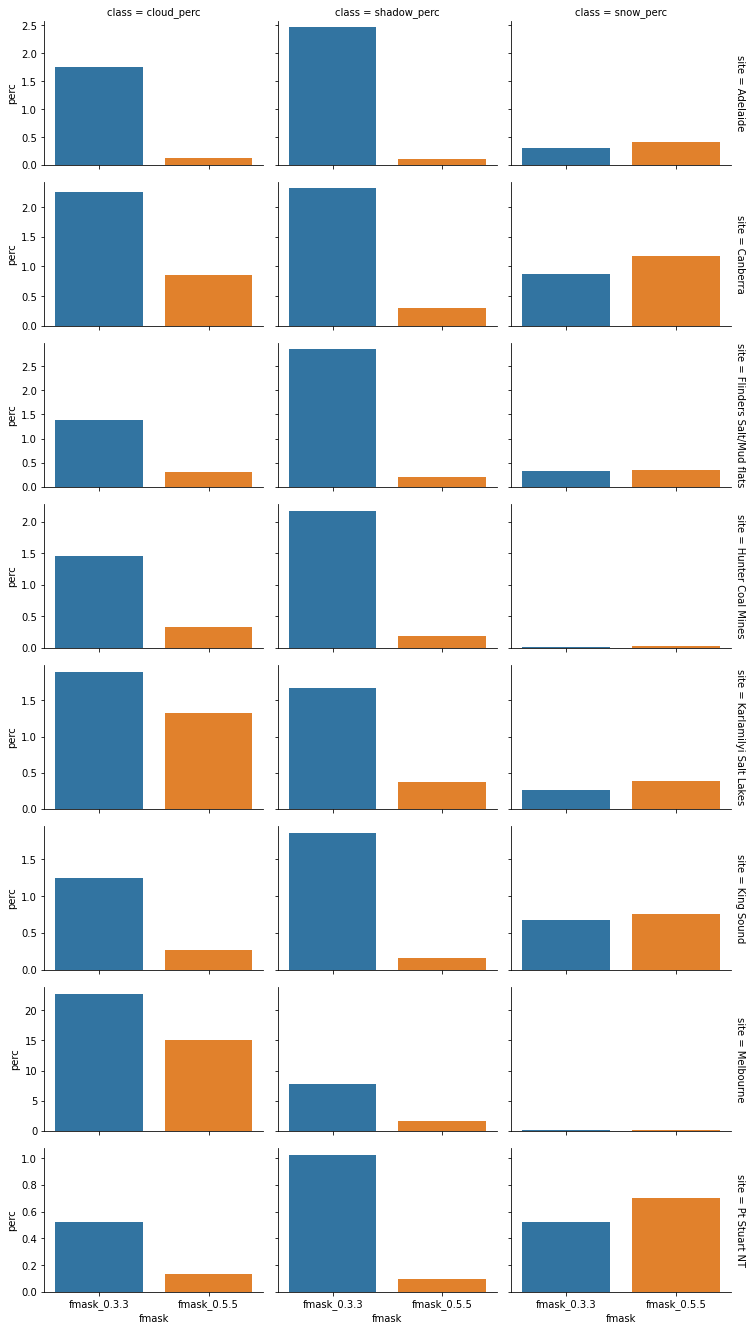

In [76]:
import seaborn as sns
sns_plot = sns.catplot(x='fmask', y='perc', 
            data=all_melted_df, 
            kind='bar', 
            col='class', 
            row='site', 
            height=2.3, 
            aspect=1.5, 
            margin_titles=True, 
            sharey="row",
           )

sns_plot.savefig("output.png")


In [ ]:
# from datacube.utils.cog import write_cog
# write_cog(s2_current_stats_df.fmask, 'test3.tif')

In [1]:
!aws s3 ls --recursive s3://dea-public-data/baseline/ga_s2am_ard_provisional_3/ | grep '2021/09/07' | grep 'fmask.tif$'
# aws s3 ls --recursive s3://dea-public-data-dev/baseline/ga_s2am_ard_provisional_3/ | grep '2021/09/07' | grep 'fmask.tif$'


An error occurred (InvalidAccessKeyId) when calling the ListObjectsV2 operation: The AWS Access Key Id you provided does not exist in our records.


In [58]:
out = stac_search(product='ga_s2bm_ard_provisional_3', 
            start_time='2021-09-07', 
            end_time='2021-09-08', 
            bbox=None, 
            root_url='https://explorer-aws.dea.ga.gov.au/stac')

In [64]:
url = 's3://dea-public-data-dev/baseline/ga_s2am_ard_provisional_3/50/HNG/2021/09/07_nrt/20210907T052538/ga_s2am_oa_provisional_3-2-1_50HNG_2021-09-07_nrt_fmask.tif'

# Get https URL
bucket, key = odc.aws.s3_url_parse(url)
#         https_url = f'https://dea-public-data-dev.s3.ap-southeast-2.amazonaws.com/{key}'
https_url = f'https://dea-public-data.s3.ap-southeast-2.amazonaws.com/{key}'
https_url

'https://dea-public-data.s3.ap-southeast-2.amazonaws.com/baseline/ga_s2am_ard_provisional_3/50/HNG/2021/09/07_nrt/20210907T052538/ga_s2am_oa_provisional_3-2-1_50HNG_2021-09-07_nrt_fmask.tif'

In [59]:
import odc.aws

for i in out['features']:
    
    try:

        url = i['assets']['oa_fmask']['href']

        # Get https URL
        bucket, key = odc.aws.s3_url_parse(url)
        https_url = f'https://dea-public-data-dev.s3.ap-southeast-2.amazonaws.com/{key}'
#         https_url = f'https://dea-public-data.s3.ap-southeast-2.amazonaws.com/{key}'
        https_url

        import urllib.request

        # Download the file from `url` and save it locally under `file_name`:
        urllib.request.urlretrieve(https_url, https_url.split('/')[-1])
    except:
        print(f"Failed {https_url.split('/')[-1]}")


Failed ga_s2bm_oa_provisional_3-2-1_53KQT_2021-09-07_nrt_fmask.tif
Failed ga_s2bm_oa_provisional_3-2-1_53KPT_2021-09-07_nrt_fmask.tif
Failed ga_s2bm_oa_provisional_3-2-1_53KNT_2021-09-07_nrt_fmask.tif
Failed ga_s2bm_oa_provisional_3-2-1_53KMT_2021-09-07_nrt_fmask.tif
Failed ga_s2bm_oa_provisional_3-2-1_53KQS_2021-09-07_nrt_fmask.tif
Failed ga_s2bm_oa_provisional_3-2-1_53KPS_2021-09-07_nrt_fmask.tif
Failed ga_s2bm_oa_provisional_3-2-1_53KNS_2021-09-07_nrt_fmask.tif
Failed ga_s2bm_oa_provisional_3-2-1_53KMS_2021-09-07_nrt_fmask.tif
Failed ga_s2bm_oa_provisional_3-2-1_53KQR_2021-09-07_nrt_fmask.tif
Failed ga_s2bm_oa_provisional_3-2-1_53KPR_2021-09-07_nrt_fmask.tif
Failed ga_s2bm_oa_provisional_3-2-1_53KNR_2021-09-07_nrt_fmask.tif
Failed ga_s2bm_oa_provisional_3-2-1_53KQQ_2021-09-07_nrt_fmask.tif
Failed ga_s2bm_oa_provisional_3-2-1_53KMR_2021-09-07_nrt_fmask.tif
Failed ga_s2bm_oa_provisional_3-2-1_53KPQ_2021-09-07_nrt_fmask.tif
Failed ga_s2bm_oa_provisional_3-2-1_53KNQ_2021-09-07_nrt_fmask

In [2]:
out = !aws s3 --no-sign-request ls --recursive s3://dea-public-data-dev/baseline/ga_s2am_ard_provisional_3/ | grep '2021/09/09' | grep 'fmask.tif$'

In [3]:
# sites = ['50HLK', '50KNC', '50KQC', '51KVV', '52LGM', '53JNF', '54HTG', '55GEN', '55HBT', '55HBU', '55HCT', '55HCU', '56JMQ', '56JNQ']
sites = ['55GDQ', '55HBD', '55HDT', '55HFA', '55KCB', '55KDV', '55KEU', '55KGS', '56HLJ', '56JMT', '56JNN', '56JNP', '56KKU']

In [4]:
keys = [i.split(' ')[-1] for i in out]
[string for string in keys if any(substring in string for substring in sites)]

[]

In [61]:
key = keys[-1]
f'https://dea-public-data-dev.s3.ap-southeast-2.amazonaws.com/{key}'

'https://dea-public-data-dev.s3.ap-southeast-2.amazonaws.com/baseline/ga_s2am_ard_provisional_3/54/LXP/2021/09/09_nrt/20210909T022347/ga_s2am_oa_provisional_3-2-1_54LXP_2021-09-09_nrt_fmask.tif'

In [62]:
f'https://dea-public-data.s3.ap-southeast-2.amazonaws.com/{key}'

'https://dea-public-data.s3.ap-southeast-2.amazonaws.com/baseline/ga_s2am_ard_provisional_3/54/LXP/2021/09/09_nrt/20210909T022347/ga_s2am_oa_provisional_3-2-1_54LXP_2021-09-09_nrt_fmask.tif'

In [63]:
key = key.replace('fmask', 'band02').replace('oa', 'nbart')
f'https://dea-public-data.s3.ap-southeast-2.amazonaws.com/{key}'


'https://dea-public-data.s3.ap-southeast-2.amazonaws.com/baseline/ga_s2am_ard_provisional_3/54/LXP/2021/09/09_nrt/20210909T022347/ga_s2am_nbart_provisional_3-2-1_54LXP_2021-09-09_nrt_band02.tif'

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** December 2019

**Compatible datacube version:** 

In [28]:
print(datacube.__version__)

1.8.4.dev81+g80d466a2


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)